# Convolutional Tuned Model

In the final iteration of my neural network, I add in 1D convolutional layers that are motivated by the physical phenomenon of absorption bands in my spectral data. Also, the dense layers are tuned via keras tuner to produce the most ideal results.

The results of this model turned out to be the best, so further analysis was performed. To explain what this model is looking at in my data, I created another model which stopped after the first convolutional layer. These results are listed below and are interpreted to show which spectral bands are the most important in discriminating between different lithologies at the Gruithuisen Domes.

### Importing Packages

In [1]:
#Local Imports
from classifyhyspecmoon.neuralnetdata import NeuralNetData
from classifyhyspecmoon.buildNN import run_mlp,MyHyperParameters,tune_model

#Remote Imports
import matplotlib.pyplot as plt
from matplotlib import ticker
import matplotlib.font_manager as fnt_mang
import numpy as np
from matplotlib.colors import ListedColormap

Thank you for using ClassifyHySpecMoon by z-vig!



Loaded in data of shape: (239, 584, 408)
Reminder: (bands,ydimension,xdimension)


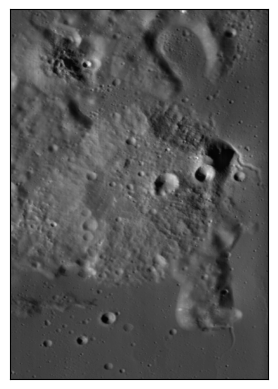

In [2]:
#Getting Raw Spectral Data and placing it in mydata ojbect.
mydata = NeuralNetData('targeted.hdf5')
print(f'Loaded in data of shape: {mydata.smoothspec.shape}')
print(f'Reminder: (bands,ydimension,xdimension)')
plt.imshow(mydata.smoothspec[200,:,:],cmap='gray')
plt.xticks([]); plt.yticks([])
plt.savefig('m3_image.png',dpi=800)

### Label Creation for Supervised Learning

In [3]:
#Creating data labels based on the Spectral ANgle Mapper (SAM) technique.

# Defining reference spectra for labeling.
olpt = (200,284)
refspec1 = mydata.smoothspec[:,*olpt] #olivine
olcheck = mydata.contrem[:,*olpt]
refspec2 = mydata.smoothspec[:,500,200] #mare (South)
refspec3 = mydata.smoothspec[:,190,360] #mare (North)
refspec4 = mydata.smoothspec[:,300,200] #dome center
refspec5 = mydata.smoothspec[:,320,100] #dome flank
refspec_raw = mydata.rawspec[:,200,280]
refspec_dict = {'Olivine':(refspec1,1.2),'Mare1':(refspec2,1),'Mare2':(refspec3,0.7),'Dome1':(refspec4,1),'Dome2':(refspec5,1)} #Dictionary of tuples {str:(array,threshold)}

#Labeling data by modifying mydata object
mydata.label_data('Spectral_Angle',refspec_dict)

c:\Users\josep\Documents\GitHub\ClassifyHySpecMoon\classifyhyspecmoon\create_labels.py:23: RuntimeWarning: invalid value encountered in arccos
  spa = 180*np.arccos(np.einsum('ijk,ijk->ij',M,I)/(np.linalg.norm(M,axis=2)*np.linalg.norm(I,axis=2)))/np.pi


(-0.5, 407.5, 583.5, -0.5)

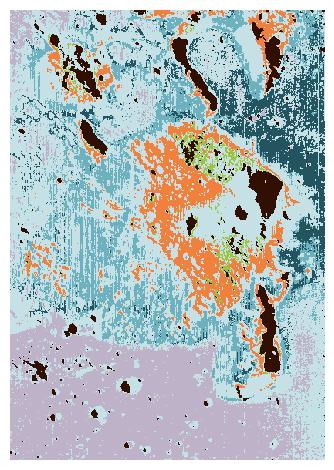

In [9]:
c_map = ListedColormap(['#310f02','#9BC53D','#BEB2C8','#225560','#F0803C','#6DB1BF','#C6E1E6'])

# ref_pts = [(olpt[1],olpt[0]),(200,500),(360,190),(200,300),(100,320)]
fig2,ax2 = plt.subplots(1,layout='tight')
ax2.imshow(mydata.labeled_data,interpolation='none',cmap=c_map)
ax2.axis('off')
# for i in range(0,len(ref_pts)):
#     ax2.scatter(*ref_pts[i],color = c[i+1],edgecolors='red')

In [4]:
#Converts integer labels to one-hot encoded labels
mydata.onehot_encoding()

### Setting Up Model Tuning

In [53]:
# Setting up the keras tuner
import keras_tuner
tuner = keras_tuner.RandomSearch(
    hypermodel=tune_model,
    objective='val_loss',
    max_trials=5,
    overwrite=True,
    project_name='aosc_project'
)
#summarizing search space
tuner.search_space_summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d_4 (Conv1D)           (None, 239, 10)           310       
                                                                 
 max_pooling1d_4 (MaxPoolin  (None, 119, 10)           0         
 g1D)                                                            
                                                                 
 conv1d_5 (Conv1D)           (None, 105, 10)           1510      
                                                                 
 max_pooling1d_5 (MaxPoolin  (None, 52, 10)            0         
 g1D)                                                            
                                                                 
 flatten_2 (Flatten)         (None, 520)               0         
                                                                 
 dense_5 (Dense)             (None, 10)               

In [10]:
#splitting testing and training data
mydata.split_train_test()
#normalizing data
mydata.minmax_normalization((0,1))
print(mydata.X_train.shape)

(178704, 239)


In [54]:
#Searching the model space with keras_tuner
from sklearn.utils.class_weight import compute_class_weight

#setting up class weights
train_decoded = np.argmax(mydata.Y_train,axis=1)
class_weight_dict = dict(enumerate(compute_class_weight('balanced',
                                        classes=np.unique(train_decoded),
                                        y=train_decoded)))
mydata.get_validation_data()

#running the serach
tuner.search(mydata.X_train_noval,mydata.Y_train_noval,
             epochs=2,
             validation_data=(mydata.X_val,mydata.Y_val),
             class_weight = class_weight_dict
             )
tuner.results_summary()

Trial 5 Complete [00h 00m 41s]
val_loss: nan

Best val_loss So Far: 0.35990917682647705
Total elapsed time: 00h 03m 31s
Results summary
Results in .\aosc_project
Showing 10 best trials
Objective(name="val_loss", direction="min")

Trial 3 summary
Hyperparameters:
n_layers: 3
units_0: 40
units_1: 110
activation_0: relu
activation_1: relu
learning_rate: 0.01
batch_size: 1500
units_2: 10
activation_2: relu
Score: 0.35990917682647705

Trial 1 summary
Hyperparameters:
n_layers: 2
units_0: 30
units_1: 60
activation_0: relu
activation_1: relu
learning_rate: 0.001
batch_size: 1200
Score: 0.4012809991836548

Trial 2 summary
Hyperparameters:
n_layers: 2
units_0: 180
units_1: 70
activation_0: tanh
activation_1: tanh
learning_rate: 1.0
batch_size: 800
Score: 0.40682563185691833

Trial 0 summary
Hyperparameters:
n_layers: 2
units_0: 190
units_1: 20
activation_0: tanh
activation_1: relu
learning_rate: 10.0
batch_size: 1000
Score: nan

Trial 4 summary
Hyperparameters:
n_layers: 3
units_0: 150
units_1:

### Training the Tuned Model

In [102]:
nepochs = 15

#Retuning the best model from keras_tuner on the entire dataset
best_model = tuner.get_best_models(num_models=1)[0]
# best_model.save('tuned_model.keras')



Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d (Conv1D)             (None, 239, 10)           310       
                                                                 
 max_pooling1d (MaxPooling1  (None, 119, 10)           0         
 D)                                                              
                                                                 
 conv1d_1 (Conv1D)           (None, 105, 10)           1510      
                                                                 
 max_pooling1d_1 (MaxPoolin  (None, 52, 10)            0         
 g1D)                                                            
                                                                 
 flatten (Flatten)           (None, 520)               0         
                                                                 
 dense (Dense)               (None, 40)                2

In [288]:
import keras
# activ = keras.activations.relu
# activ = keras.activations.softmax
# activ = keras.activations.tanh
activ = keras.activations.elu
# activ = keras.layers.LeakyReLU

model = keras.Sequential()
model.add(keras.layers.Input(shape=(239,1)))
model.add(keras.layers.Conv1D(
        filters = 10,
        kernel_size = 30,
        strides = 1,
        padding = "same",
        input_shape = (239,1) #roughly matching a 1 micron band size
    ))
model.add(keras.layers.MaxPooling1D(
    pool_size=2
))

model.add(keras.layers.Conv1D(
    filters = 10,
    kernel_size = 15,
    strides = 1,
input_shape = (239,1) #roughly matching a 1 micron band size
))

model.add(keras.layers.MaxPooling1D(
    pool_size=2
))

model.add(keras.layers.Flatten())


# for i in range(0,3):
#     model.add(keras.layers.Dense(units=hpms.npl[i],activation=keras.activations.relu))
model.add(keras.layers.Dense(units=80,activation=activ))
# model.add(keras.layers.Dense(units=40,activation=activ))
# model.add(keras.layers.Dense(units=10,activation=activ))

model.add(keras.layers.Dense(units=7,activation="softmax")) #SOFTMAX WAS THE KEY!!

lr_schedule = keras.optimizers.schedules.CosineDecay(
    # initial_learning_rate = 1e-3,
    initial_learning_rate = 1e-5,
    
    decay_steps=4468*nepochs,
    # alpha=1e-2,
    alpha=1e-1,
    name="CosineDecay",
    # warmup_target=None,
    warmup_target=1e-3,
    warmup_steps=4468,
)

lr_schedule2 = keras.optimizers.schedules.CosineDecayRestarts(
    initial_learning_rate= 1e-3,
    first_decay_steps = 4468*nepochs/15,        # 1 -> 3 -> 7 -> 15
    t_mul=2.0,
    m_mul=1.0,
    alpha=1e-1,
    name='SGDRDecay'
)

model.compile(
    # optimizer = keras.optimizers.SGD(learning_rate=.1),
    optimizer = keras.optimizers.Adam(learning_rate=lr_schedule2),
    loss='CategoricalCrossentropy',
    metrics=['accuracy']
    )

model.summary()


Model: "sequential_72"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d_139 (Conv1D)         (None, 239, 10)           310       
                                                                 
 max_pooling1d_100 (MaxPool  (None, 119, 10)           0         
 ing1D)                                                          
                                                                 
 conv1d_140 (Conv1D)         (None, 105, 10)           1510      
                                                                 
 max_pooling1d_101 (MaxPool  (None, 52, 10)            0         
 ing1D)                                                          
                                                                 
 flatten_72 (Flatten)        (None, 520)               0         
                                                                 
 dense_166 (Dense)           (None, 80)              

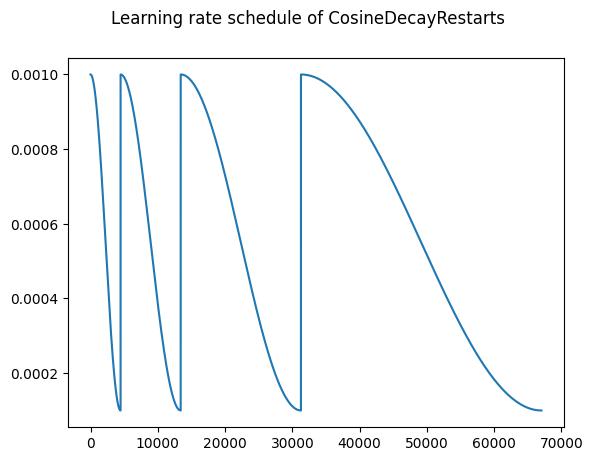

In [198]:
from visualize import visualize_lr_schedule     ## stole from github. check visualize.py
steps, lr_values = visualize_lr_schedule(lr_schedule2, n_steps=4468*nepochs, step_s=3)

In [203]:
model.save('hand_tuned_model2.keras')

In [289]:
import keras
# best_model  = keras.models.load_model('tuned_model.keras')
nepochs = 15

hist = model.fit(
# hist = best_model.fit(
    x = mydata.X_train,
    y = mydata.Y_train,
    epochs = nepochs,
    validation_split=0.2,
    class_weight = class_weight_dict
)

Epoch 1/15
4468/4468 [==============================] - 22s 5ms/step - loss: 0.5347 - accuracy: 0.6462 - val_loss: 0.5617 - val_accuracy: 0.7723
Epoch 2/15
4468/4468 [==============================] - 23s 5ms/step - loss: 0.3269 - accuracy: 0.7577 - val_loss: 0.4496 - val_accuracy: 0.8212
Epoch 3/15
4468/4468 [==============================] - 20s 4ms/step - loss: 0.2053 - accuracy: 0.8333 - val_loss: 0.3760 - val_accuracy: 0.8483
Epoch 4/15
4468/4468 [==============================] - 19s 4ms/step - loss: 0.2689 - accuracy: 0.8043 - val_loss: 0.4596 - val_accuracy: 0.8211
Epoch 5/15
4468/4468 [==============================] - 20s 4ms/step - loss: 0.2035 - accuracy: 0.8434 - val_loss: 0.3419 - val_accuracy: 0.8566
Epoch 6/15
4468/4468 [==============================] - 20s 4ms/step - loss: 0.1520 - accuracy: 0.8765 - val_loss: 0.2225 - val_accuracy: 0.9078
Epoch 7/15
4468/4468 [==============================] - 19s 4ms/step - loss: 0.1199 - accuracy: 0.8993 - val_loss: 0.2355 - val_ac

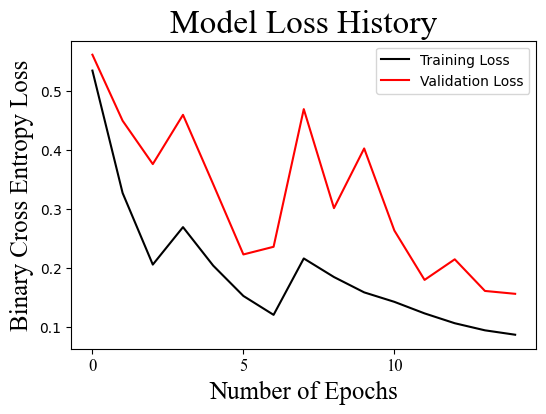

In [290]:
#plotting loss history
fancyfont = {'fontname':'Times New Roman'}
font = fnt_mang.FontProperties(family='Times New Roman',style='normal',size=10)

#Loss-validation curve
# best_model.summary()
# model.summary()

# print(mydata.Y_train)
fig,ax = plt.subplots(1,1,figsize=(6,4))
ax.plot(range(0,nepochs),hist.history['loss'],c='k',label='Training Loss')
ax.plot(range(0,nepochs),hist.history['val_loss'],c='r',label='Validation Loss')
ax.legend()

ax.set_title('Model Loss History',**fancyfont,fontsize=24)
ax.set_xlabel('Number of Epochs',**fancyfont,fontsize=18)
ax.set_ylabel('Binary Cross Entropy Loss',**fancyfont,fontsize=18)
ax.set_xticks(np.arange(0,nepochs,5),labels=np.arange(0,nepochs,5),**fancyfont,fontsize=12)
# ax.set_yticks(np.arange(1.5,4.5,0.5),labels=np.arange(1.5,4.5,0.5),**fancyfont,fontsize=12)
# plt.ylim(0,0.5)

# plt.savefig('G:/My Drive/Machine Learning Project/Figures/Loss_History_onehot.png',dpi=300)

### Evaluating the Model

In [291]:
#Predicting test dataset
# pred_encoded = best_model.predict(
pred_encoded = model.predict(
    x = mydata.X_test
)

1862/1862 [==============================] - 3s 1ms/step


Training Data: 178704 (75%)
Testing Data: 59568 (25%)
Labeled Training Data: 59568
Predicted Test Data: 59568
starting accuracy: 0.894960
current accuracy: 0.934864


([], [])

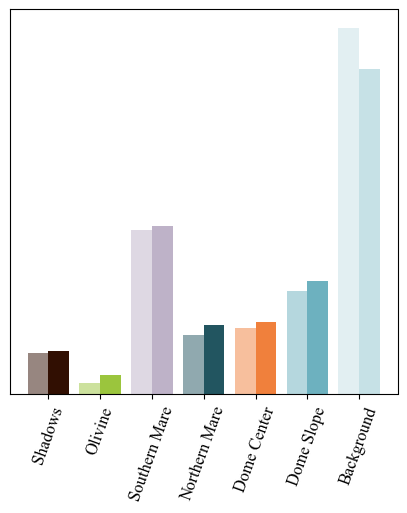

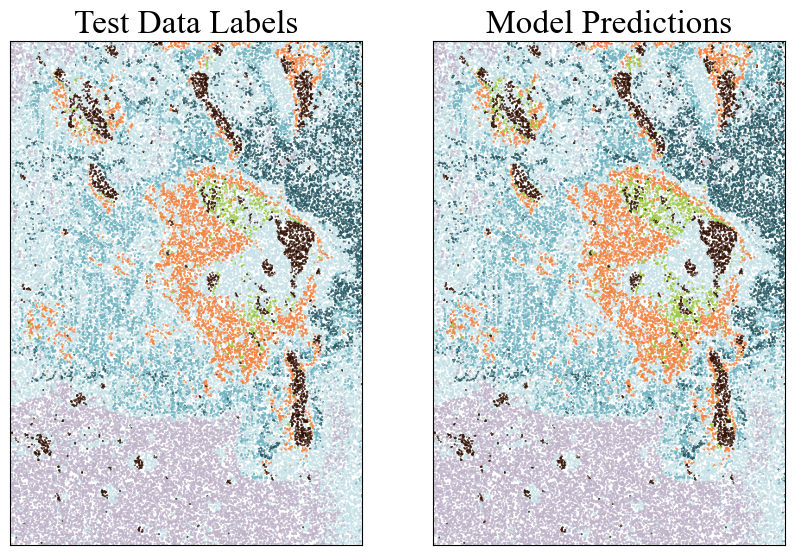

In [292]:
#Comparing predictions versus test labels
c = ['#310f02','#9BC53D','#BEB2C8','#225560','#F0803C','#6DB1BF','#C6E1E6']
c_map = ListedColormap(['#310f02','#9BC53D','#BEB2C8','#225560','#F0803C','#6DB1BF','#C6E1E6'])
class_names = ['Shadows','Olivine','Southern Mare','Northern Mare','Dome Center', 'Dome Slope','Background']

lab = np.argmax(mydata.Y_test,axis=1)
pred = np.argmax(pred_encoded,axis=1)


label_dist = {}
pred_dist = {}
accuracy = 0
for i in range(0,len(class_names)):
    label_dist[class_names[i]] = mydata.Y_test[lab==i].shape[0]
    pred_dist[class_names[i]] = pred[pred==i].shape[0]

print(f'Training Data: {len(mydata.Y_train)} ({len(mydata.Y_train)/mydata.num_pixels:.0%})')
print(f'Testing Data: {len(mydata.Y_test)} ({len(mydata.Y_test)/mydata.num_pixels:.0%})')
tot_label = np.array(list(label_dist.values())).sum()
tot_pred = np.array(list(pred_dist.values())).sum()
print(f'Labeled Training Data: {tot_label}')
print(f'Predicted Test Data: {tot_pred}')

# print(label_dist.values())
# print(pred_dist.values())

# print(mydata.Y_test)        # toggle to see that data comes out as categoricalcrossentropy
# print(pred_encoded)
# print(lab)
# print(pred)
for i in range(lab.shape[0]):
    if lab[i] == pred[i]:
        accuracy +=1
# accuracy / lab.shape[0]
print(f'starting accuracy: 0.894960')
print(f'current accuracy: {accuracy/ lab.shape[0] :.6f}')


#Class Distributions
fig1,ax = plt.subplots(1,1,figsize=(5,5))
width=0.4
ax.bar(np.arange(0,len(class_names))-width/2,list(label_dist.values()),width=width,color=c,alpha=0.5)
ax.bar(np.arange(0,len(class_names))+width/2,list(pred_dist.values()),width=width,color=c)
ax.set_xticks(np.arange(0,len(class_names)))
ax.set_xticklabels(class_names,**fancyfont,fontsize=12,rotation=70)
ax.set_yticks([])

# plt.savefig('G:/My Drive/Machine Learning Project/Figures/Class_distribution_conv.png',dpi=800)

#Spatial Relations

fig2,[ax1,ax2] = plt.subplots(1,2,figsize=(10,12))
ax1.imshow(mydata.labeled_data,interpolation='none',cmap=c_map,alpha=0)
ax1.scatter(mydata.xcoord_test,mydata.ycoord_test,marker='.',s=0.8,c=lab,cmap=c_map,vmin=0,vmax=6)

ax2.imshow(mydata.labeled_data,interpolation='none',cmap=c_map,alpha=0)
ax2.scatter(mydata.xcoord_test,mydata.ycoord_test,marker='.',s=0.8,c=pred,cmap=c_map,vmin=0,vmax=6)

ax1.set_title('Test Data Labels',fontdict={'size':24,'family':'Times New Roman'})
ax2.set_title('Model Predictions',fontdict={'size':24,'family':'Times New Roman'})

ax1.set_xticks([]),ax1.set_yticks([])
ax2.set_xticks([]),ax2.set_yticks([])

# print(np.count_nonzero(mydata.Y_test==6))
# print(np.count_nonzero(pred==6))

# print(np.array(list(label_dist.values())).sum())
# print(np.array(list(pred_dist.values())).sum())

# plt.savefig('G:/My Drive/Machine Learning Project/Figures/Model_Performance_convolutional.png',dpi=800)


([<matplotlib.axis.YTick at 0x16bfa80b410>,
 [Text(0, 0, 'Shadows'),
  Text(0, 1, 'Olivine'),
  Text(0, 2, 'Southern Mare'),
  Text(0, 3, 'Northern Mare'),
  Text(0, 4, 'Dome Center'),
  Text(0, 5, 'Dome Slope'),
  Text(0, 6, 'Background')])

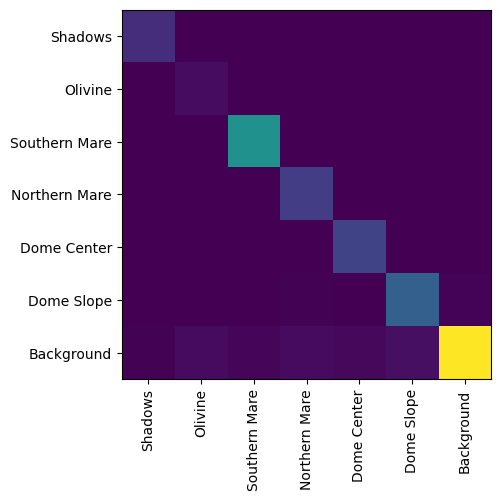

In [293]:
#Plotting a confusion matrix
import sklearn.metrics

conf = sklearn.metrics.confusion_matrix(lab,pred)
plt.imshow(conf)
plt.xticks(np.arange(7),class_names,rotation=90)
plt.yticks(np.arange(7),class_names)
# plt.savefig('G:/My Drive/Machine Learning Project/Figures/Confusion_Matrix_conv.png',dpi=400)

### Explaining Model Behavior

(10, 30)


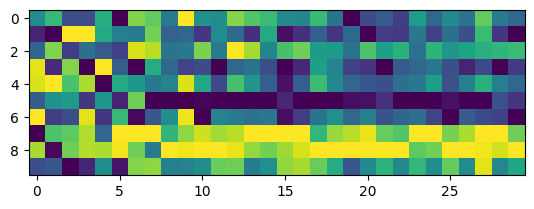

In [294]:
#Getting filters from the first convolutional layer of my model.
from sklearn.preprocessing import MinMaxScaler

filters,biases = best_model.layers[0].get_weights()
filters = np.transpose(np.squeeze(filters))
print(filters.shape)
scaler = MinMaxScaler((0,1),copy=False)
scaler.fit_transform(filters)
plt.imshow(filters)

In [295]:
#Here, I create a new model with just the first convolutional layer weights and predict a single spectrum to understand where the 1D convolution is looking
import keras
filter_model = keras.Sequential()
filter_model.add(model.input)
filter_model.add(model.layers[0])

feature_maps = filter_model.predict(mydata.X_train[1,:][np.newaxis,:])
feature_maps = np.squeeze(feature_maps)
scaler.fit_transform(feature_maps)


1/1 [==============================] - 0s 45ms/step


array([[0.05502975, 0.3648657 , 0.4465282 , ..., 1.        , 0.01158589,
        0.03150886],
       [0.05138257, 0.29520604, 0.5263023 , ..., 0.9826101 , 0.0485765 ,
        0.12599617],
       [0.06142426, 0.22562772, 0.641739  , ..., 0.9067955 , 0.05774719,
        0.10023981],
       ...,
       [0.98241127, 0.7380596 , 0.1681046 , ..., 0.16564664, 0.8216227 ,
        0.9252659 ],
       [0.99999994, 0.8908798 , 0.04777732, ..., 0.21817651, 0.8012719 ,
        0.90614015],
       [0.9535678 , 1.        , 0.        , ..., 0.23574826, 0.85321045,
        1.        ]], dtype=float32)

(239, 10)


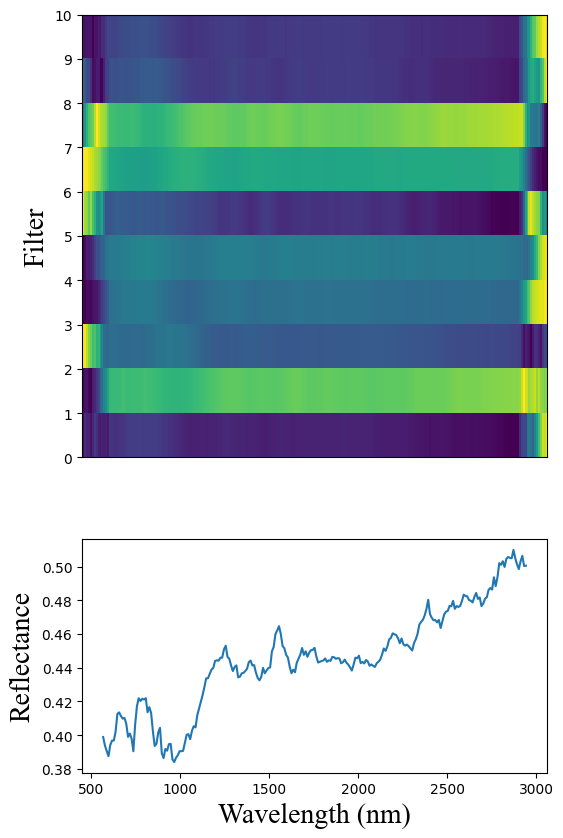

In [296]:
#Plotting filters
fig,[ax1,ax2] = plt.subplots(2,1,height_ratios=[2,1],figsize=(6,10))
ax1.imshow(np.transpose(feature_maps),extent = [0,210,0,10], aspect = 20, interpolation='None')
ax2.plot(mydata.wvl,mydata.X_train[1,:])
ax1.set_xticks([])
ax1.set_yticks(np.arange(0,11))

ax1.set_ylabel('Filter',**fancyfont,fontsize=20)
ax2.set_xlabel('Wavelength (nm)',**fancyfont,fontsize=20)
ax2.set_ylabel('Reflectance',**fancyfont,fontsize=20)
print(feature_maps.shape)
# plt.savefig('G:/My Drive/Machine Learning Project/Figures/Spectrum_Weights.png',dpi=800)